# Proof of concept for one pixel attacks in qml
- some code parts taken from:
  - https://discuss.pennylane.ai/t/quantum-machine-learning-in-feature-hilbert-spaces/374/13
  - https://pennylane.ai/qml/demos/tutorial_How_to_optimize_QML_model_using_JAX_and_JAXopt
  - https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
  - https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning
  - https://suyongeum.com/B5G6G/info/QSVM-Kernel-method-sample.html

In [1]:
#imports
from sklearn.datasets import load_digits       # Loading MNIST data using the function "load_digits" provided by sklearn package
import numpy as np                             # To use "SVD" function provided by numpy module
import matplotlib.pylab as plt                 # Matplot is a library to plot a graph

from sklearn.model_selection import train_test_split

import pennylane as qml
from pennylane import numpy as np
import torch

## Read in MNIST

In [2]:
digits = load_digits()                         # Loading MNIST data: each digit has 8 by 8 dimension
data, label = digits.data, digits.target 

## Only process for two labels (0,1)

In [3]:
data_0 = [[item] for item, l in zip(data, label) if l == 0][0:-1]
data_1  = [[item] for item, l in zip(data, label) if l == 1][0:-1]
train_features = np.array(data_0 + data_1)
train_labels   = np.array([0.]*len(data_0) + [1.]*len(data_1))
print(f"# of each data 0 is {len(data_0)}.")
print(f"# of each data 1 is {len(data_1)}.")

# of each data 0 is 177.
# of each data 1 is 181.


## prepare data for amplitude encoding -> only 6 qubits needed

In [4]:
train_features_converted = []
for feature in train_features:
    sum = np.sum(feature)
    train_features_converted.append(feature/sum)

train_features_converted = np.array(train_features_converted)

In [5]:
print(f"train_features: {train_features.shape} ")
print(f"train_features_converted: {train_features_converted.shape} ")
print(f"train_labels: {train_labels.shape} ")

train_features: (358, 1, 64) 
train_features_converted: (358, 1, 64) 
train_labels: (358,) 


In [6]:
train_labels

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

In [7]:
train_features_converted

tensor([[[0.        , 0.        , 0.0170068 , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.00310559, ..., 0.00931677,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.00890208, ..., 0.01186944,
          0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.0106383 , ..., 0.00531915,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.00286533, ..., 0.0286533 ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.01909308, ..., 0.01670644,
          0.        , 0.        ]]], requires_grad=True)

## split in train and test set

In [8]:
# split dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    train_features_converted, train_labels, train_size=0.8, random_state=42
)

## Define and train our model

In [9]:
# Construct variational circuit
n_wires = 6

dev = qml.device("default.qubit", wires=n_wires)
@qml.qnode(dev)
def circuit(weights, x):
    # data embedding
    qml.AmplitudeEmbedding(features=x, wires=range(n_wires), normalize=True)
    #trainable ansatz
    for i in range(n_wires):
        qml.RX(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)
        qml.CNOT(wires=[i, (i + 1)% n_wires])
        
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(weights, bias, x):
    return circuit(weights, x) + bias

In [10]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [11]:
def accuracy(labels, predictions):
    acc = np.sum(np.abs(l - p) < 1e-5 for l, p in zip(labels, qml.math.stack(predictions)))
    acc = acc / len(labels)
    return acc

In [12]:
def cost(weights, bias, X, Y):
    predictions = [my_model(weights, bias, x[0]) for x in X]
    return square_loss(Y, predictions)

In [13]:
# initialize parameters
weights = np.ones([n_wires, 3], requires_grad=True)
bias = np.array(0.0, requires_grad=True)

In [14]:
opt = qml.GradientDescentOptimizer(stepsize = 0.3)

In [15]:
costs = []

In [16]:
for i in range(200):
    weights, bias = opt.step(cost, weights, bias, X=X_train, Y=Y_train)
    if i%10 == 0:
        cur_cost = cost(weights, bias, X_train, Y_train)
        print(f"Step = {i} Costs = {cur_cost}")
        costs.append(cur_cost)

Step = 0 Costs = 0.36569848539619554
Step = 10 Costs = 0.20641809867051855
Step = 20 Costs = 0.13158109329034154
Step = 30 Costs = 0.08765671138053638
Step = 40 Costs = 0.06795264935979528
Step = 50 Costs = 0.05658087046847368
Step = 60 Costs = 0.048624551240819346
Step = 70 Costs = 0.042930039956875776
Step = 80 Costs = 0.038874042078203955
Step = 90 Costs = 0.03595463978549054
Step = 100 Costs = 0.033800397118089964
Step = 110 Costs = 0.032158797109841895
Step = 120 Costs = 0.03086439682724203
Step = 130 Costs = 0.029809609448021652
Step = 140 Costs = 0.028923922306088076
Step = 150 Costs = 0.028160416103450953
Step = 160 Costs = 0.02748730703857024
Step = 170 Costs = 0.026882676798415946
Step = 180 Costs = 0.026331167410061758
Step = 190 Costs = 0.025821879351944584


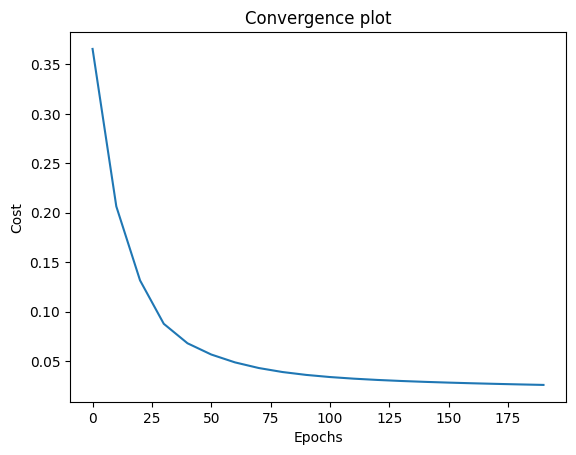

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(range(0,200,10), costs)
ax1.set(xlabel='Epochs', ylabel='Cost', title='Convergence plot')
plt.show()

## Result of our model

In [18]:
test_predictions = [my_model(weights, bias, x[0]) for x in X_test]

In [19]:
print(Y_test)
print(test_predictions)

[1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1.]
[tensor(1.08455005, requires_grad=True), tensor(0.1337784, requires_grad=True), tensor(1.02770188, requires_grad=True), tensor(1.1232855, requires_grad=True), tensor(0.01957066, requires_grad=True), tensor(0.8089205, requires_grad=True), tensor(0.06156124, requires_grad=True), tensor(0.16178589, requires_grad=True), tensor(1.2194741, requires_grad=True), tensor(0.26098276, requires_grad=True), tensor(-0.00633896, requires_grad=True), tensor(1.27602718, requires_grad=True), tensor(1.04762001, requires_grad=True), tensor(0.79050323, requires_grad=True), tensor(0.15895313, requires_grad=True), tensor(0.08035272, requires_grad=True), tensor(1.01551089, requires_grad=True), tensor(0.2460265, requires_grad=True), tensor(0.24789256, requires_grad=True), tensor(1.09742318, requ

In [20]:
# check if model training is going well!
test_pred_round = np.rint(test_predictions)
print(test_pred_round)

[ 1.  0.  1.  1.  0.  1.  0.  0.  1.  0. -0.  1.  1.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  1.  0.  1.  1. -0.  1.  0.  0.  1. -0.  1.  0. -0.  0.
  0.  1. -0. -0.  1. -0.  1.  0.  0.  1.  0. -0.  0.  1.  1.  1.  1. -0.
  1.  1. -0. -0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.]


In [21]:
acc_val = accuracy(Y_test, test_predictions)
acc_val_round = accuracy(Y_test, test_pred_round)
print(f"Accuracy orig values: {acc_val}")
print(f"Accuracy rounded values: {acc_val_round}")

Accuracy orig values: 0.0
Accuracy rounded values: 1.0


## Pick one image and try to attack

In [22]:
# take one index
attack_idx = np.random.randint(0, len(Y_test))
print(f"Attack index: {attack_idx}")

Attack index: 9


In [30]:
# now pertubate image until prediction is not correct anymore
orig_pred = Y_test[attack_idx]

attack_pred = orig_pred
loop_cnt = 0

while (attack_pred == orig_pred):

    attack_img = X_test[attack_idx].copy()

    pixel_idx = np.random.randint(0, len(attack_img[0]))
    print(attack_img[0][pixel_idx])
    
    if (attack_img[0][pixel_idx] > 0.5):
        attack_img[0][pixel_idx] = 0.5
    else:
       attack_img[0][pixel_idx] = 1.0

    cur_pred = my_model(weights, bias, attack_img[0])
    print(f"model output: {cur_pred }")
    attack_pred = np.rint(cur_pred)
    print(attack_pred, " ", orig_pred)
    loop_cnt = loop_cnt + 1

print(f"Attack successfull after {loop_cnt} tries!")


0.045283018867924525
model output: -0.08620824372601021
-0.0   0.0
0.052830188679245285
model output: -0.44780264514842105
-0.0   0.0
0.018867924528301886
model output: 0.17925350718441252
0.0   0.0
0.007547169811320755
model output: 0.6680319584714551
1.0   0.0
Attack successfull after 4 tries!
